# Project description<br>
In this project we will analyze a database composed of 10,000 Beta Bank customers, with the purpose of training different Machine Learning models that can predict the permanence of customers in the bank. We will train three  algorithms (***Decision Tree***, ***Random Forest*** and ***Logistic Regression***) with a series of features that reflect the financial status and saving habits of customers, in order to have a variety of models able to predict the target variable ('Exited') with a reasonable degree of confidence.<br>

The first step will be to perform an Exploratory Data Analysis (EDA) focused on separating the ***'features'*** and ***'target'*** variables, defining the relevant features for the model, and preparing the data for machine learning using the techniques of ***One Hot Encoding (OHE)***, ***Label Encoding*** and ***Scalar Standardization***. We will then train three algorithms (Decision Tree, Random Forest and Logistic Regression) and note their initial performance, in a ***Class Imbalance*** state. In order to improve the performance of the models, we will use different techniques to mitigate class imbalance, such as the parameter ***class_weight='balanced'*** and ***upsampling/downsampling*** the training sets. After trying different combinations, we will select the optimal configuration for each algorithm and analyze the improvement in each model. Finally, we will measure the improvement in ***F1 scores*** for each model, test their reliability under different probability thresholds, and plot graphs of ***Recall-Precision curves*** and ***ROC curves with AUC-ROC*** scores to decide which model has the best performance.<br> 

## Import modules used in the project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.utils import shuffle

## Load dataset, explore and clean data

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
print(df.shape)
print(df.columns)
print(df.dtypes)
display(df.head())

(10000, 14)
Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# Find duplicated rows and null values
print("Duplicated rows:", df.duplicated().sum())
print("Null values:\n", df.isna().sum())

Duplicated rows: 0
Null values:
 RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


In [4]:
# Explore the Null values
print(df['Tenure'].unique())
print(df['Tenure'].value_counts(dropna=False).sort_index())
display(df[df['Tenure'].isnull()].head())

[ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0. nan]
0.0     382
1.0     952
2.0     950
3.0     928
4.0     885
5.0     927
6.0     881
7.0     925
8.0     933
9.0     882
10.0    446
NaN     909
Name: Tenure, dtype: int64


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


The feature 'Tenure' - period of maturation for a customer’s fixed deposit (years) is the only feature that presents null values in the dataframe. They represent a significant percentage, close to 9% of all the rows, so we can't just drop them. We must find a way to deal with the null values later, if needed, because most machine learning algorhitms cannot handle missing values. 

## Prepare the data for Machine Learning modeling
First, we will separate the dataframe in 'target' and 'feature' variables. After this we can drop the features that are not essential to the model, since the inclusion of irrelevant features will likely confuse the algorithms and yield unreliable results. Then we can make the distinction between categorical and numerical features. The categorical values can be normalized using One Hot Encoding (OHE), and Label Encoding; and the numerical values can be standardized using Feature Scaling.

In [5]:
# Define 'target' and 'feature' variables
target = df['Exited']
features = df.drop('Exited', axis=1)
print("Target shape:", target.shape)
print("Target value counts:\n", target.value_counts())
print()
print("Features shape:", features.shape)
display(features.head())

Target shape: (10000,)
Target value counts:
 0    7963
1    2037
Name: Exited, dtype: int64

Features shape: (10000, 13)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10


We can drop the following features:<br>
'RowNumber' - This feature only numerates the rows, so it doesn't offer any relevant information to the model. It is redundant because it has the same function as the index.<br>
'CustomerId', 'Surname' - These features are unique identifiers to each customer. They're nominal random features that do not have any correlation to the other features or the target. They're irrelevant to the model, so we can drop them.<br>

In [6]:
# Drop the features that are not essential to the model
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
features = features.drop(columns=columns_to_drop, axis=1)
display(features.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10


We have to explore the values for each column in the 'features' variable, to decide if they're:<br>
• Nominal categorical values (suitable for One Hot Encoding)<br>
• Ordinal categorical values (suitable for Label Encoding)<br>
• Numerical continuous values (suitable for Standard Scaling)<br>

In [7]:
# Find the array of values for each feature.
# Write a function to print unique values for each column
def print_unique_values(data):
    categorical_columns = data.columns.tolist() # create a list of columns from the input parameter
    for column in categorical_columns:
        unique_values = np.sort(data[column].unique()) # sort the unique values for each collumn
        print(f"{column}:", unique_values) # print the column name and the array of unique values

print_unique_values(features)

CreditScore: [350 351 358 359 363 365 367 373 376 382 383 386 395 399 401 404 405 407
 408 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570
 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588
 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606
 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624
 625 626 627 628 629 630 631 632 633 6

From the values displayed for each column we can assume the following distribution:<br>
• **Nominal categorical values:** 'Geography', 'Gender'<br>
• **Ordinal categorical values:** 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'<br>
• **Numerical continuous values:** 'CreditScore', 'Age', 'Balance', 'EstimatedSalary'<br>

In [8]:
# Use One Hot Encoding on the 'features' variable. 
# (Drop_first=True) drops the first dummy feature to simplify the model
features = pd.get_dummies(features, drop_first=True)
display(features.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


One Hot Encoding affected the following nominal categorical features:<br>
'Geography' - Has the values 'France', 'Germany' or 'Spain'. (OHE dropped Geography_France) <br>
'Gender' — Has the values Male or Female (OHE dropped Gender_Female).<br>
In both cases, no information is lost because a combination of 0's in the Germany and Spain columns = France, and a 0 in the Male column = Female.

In [9]:
# Use LabelEncoder on the 'features' variable. 
# Apply label encoding to the 'Tenure' column
label_encoder = LabelEncoder()
features['Tenure_encoded'] = label_encoder.fit_transform(features['Tenure'])
display(features.head())
print("Values in 'Tenure_encoded':", np.sort(features['Tenure_encoded'].unique()))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure_encoded
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0,2
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0,1
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0,8
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,1
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0,2


Values in 'Tenure_encoded': [ 0  1  2  3  4  5  6  7  8  9 10 11]


In the case of Label Encoding, the only ordinal categorical feature that we believe is valid to encode is 'Tenure', since it presents a discrete sequence of integers that represent different conditions (N years left to maturation). This approach also solves the problem of the NaN values we found earlier, since the LabelEncoder treats them as a separate category, assigning them a distinct value (Nan = 11). It makes sense to categorize NaN values, because they can also be significant for machine learning, since their presence can represent a distinct state that might be relevant to the model.<br> 
The features 'NumOfProducts', 'HasCrCard' and 'IsActiveMember' seem to be reasonably clean and formatted for machine learning. For example, if we use LabelEncoder on the 'NumOfProducts' column, the only result would be to replace the values [1,2,3,4] for [0,1,2,3]. There is no real benefit in doing this so it's best to leave values as they are.

In [10]:
# Drop the 'Tenure' column and rename the 'Tenure_encoded' column
features = features.drop('Tenure', axis=1)
features.rename(columns={'Tenure_encoded': 'Tenure'}, inplace=True)
display(features.head())
print(features.shape)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
0,619,42,0.00,1,1,1,101348.88,0,0,0,2
1,608,41,83807.86,1,0,1,112542.58,0,1,0,1
2,502,42,159660.80,3,1,0,113931.57,0,0,0,8
3,699,39,0.00,2,0,0,93826.63,0,0,0,1
4,850,43,125510.82,1,1,1,79084.10,0,1,0,2


(10000, 11)


In [11]:
# Use StandardScaler on the numeric columns
# Define a list variable with numeric columnns
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
# Apply StandardScaler to the numeric columns
scaler = StandardScaler()
scaler.fit(features[numeric])
features[numeric] = scaler.transform(features[numeric])
display(features.head())
print(features.shape)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
0,-0.326221,0.293517,-1.225848,1,1,1,0.021886,0,0,0,2
1,-0.440036,0.198164,0.117350,1,0,1,0.216534,0,1,0,1
2,-1.536794,0.293517,1.333053,3,1,0,0.240687,0,0,0,8
3,0.501521,0.007457,-1.225848,2,0,0,-0.108918,0,0,0,1
4,2.063884,0.388871,0.785728,1,1,1,-0.365276,0,1,0,2


(10000, 11)


After transforming the numeric columns with StandardScaler, the data seems to be clean and formatted for machine learning.

## Train, test and improve different Machine Learning Models

In [12]:
# Split the 'target' and 'feature' variables in training and validation sets
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

# Display shapes and first 5 rows
display(features_train.shape)
display(features_train.head())
display(features_valid.shape)
display(features_valid.head())
display(target_train.shape)
display(target_train.head())
display(target_valid.shape)
display(target_valid.head())

(7500, 11)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
226,0.449787,-0.850726,-1.225848,2,1,1,-1.271656,0,0,0,9
7756,-0.305528,-0.278604,0.638725,1,1,1,0.967754,0,1,0,7
2065,-0.253794,-0.564665,-1.225848,2,1,0,0.667982,0,0,1,8
2800,1.225795,1.151700,1.286783,2,1,0,-1.040427,0,0,1,9
7028,0.698109,-1.232140,1.138584,1,0,0,-0.851899,1,0,1,11


(2500, 11)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
7867,-0.108939,0.674932,-1.225848,1,1,1,0.976737,0,1,0,3
1402,1.101634,-0.946079,0.862589,1,1,0,-0.393354,0,0,1,8
8606,1.618972,0.293517,-1.225848,2,1,1,-0.438017,0,1,1,5
8885,0.180771,0.579578,0.416710,2,1,1,1.013588,0,1,1,4
6494,0.501521,-1.041433,-1.225848,2,1,1,-1.346004,0,0,1,7


(7500,)

226     0
7756    0
2065    0
2800    0
7028    0
Name: Exited, dtype: int64

(2500,)

7867    0
1402    0
8606    0
8885    0
6494    0
Name: Exited, dtype: int64

In [13]:
# Value_counts() of the Target variables
print(target_train.value_counts())
print(target_valid.value_counts())

0    5998
1    1502
Name: Exited, dtype: int64
0    1965
1     535
Name: Exited, dtype: int64


Since this is a classification problem, we can quickly see the balance of the classes 1 and 0 by running a value_counts(). The results show that the data is disbalanced towards Class 0.<br> 
We will train three models: **Decision Tree**, **Random Forest** and **Logistic Regression** and check their metrics (accuracy, recall, prediction and f1 score) under the class disbalance.

In [14]:
# Evaluate the best hyperparameters for DecisionTreeClassifier 
# Define variables to store best_model and best_result
best_model = None
best_result = 0

# Loop over max_depth values from 1 to 10
for depth in range(1, 11):
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=depth
    )
    model.fit(features_train, target_train)
    # Accuracy of model on training set
    predictions_train = model.predict(features_train)
    result_train = accuracy_score(target_train, predictions_train)
    # Accuracy of model on validation set
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    print('max_depth =', depth, ': ', end='')
    print(result)
    # save the model with the best accuracy on the training set
    if result > best_result:
        best_model = model
        best_result = result
print()
print("Accuracy of the model on the training set:", result_train)
print("Accuracy of the best model on the validation set:", best_result)
print("Best model on the validation set:", best_model)

max_depth = 1 : 0.786
max_depth = 2 : 0.8232
max_depth = 3 : 0.8348
max_depth = 4 : 0.8412
max_depth = 5 : 0.8496
max_depth = 6 : 0.8536
max_depth = 7 : 0.8508
max_depth = 8 : 0.8448
max_depth = 9 : 0.8432
max_depth = 10 : 0.8328

Accuracy of the model on the training set: 0.9066666666666666
Accuracy of the best model on the validation set: 0.8536
Best model on the validation set: DecisionTreeClassifier(max_depth=6, random_state=12345)


Class Frequency - Decision Tree model
0    0.8916
1    0.1084
dtype: float64

Confusion Matrix:
 [[1914   51]
 [ 315  220]]

Accuracy Score: 0.8536
Recall Score: 0.411214953271028
Precision Score: 0.8118081180811808
F1 Score: 0.5459057071960298


<AxesSubplot:>

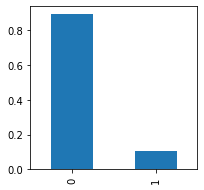

In [15]:
# 1)Decision Tree model (max_depth=6) and check its class balance.
tree = DecisionTreeClassifier(max_depth=6, random_state=12345)
tree.fit(features_train, target_train)
tree_valid = pd.Series(tree.predict(features_valid))
tree_frequency = tree_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Decision Tree model")
print(tree_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, tree_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, tree_valid))
print("Recall Score:", recall_score(target_valid, tree_valid))
print("Precision Score:", precision_score(target_valid, tree_valid))
print("F1 Score:", f1_score(target_valid, tree_valid))
tree_frequency.plot(kind='bar', figsize=(3,3))

In [16]:
# Evaluate the best hyperparameters for RandomForestClassifier
# Define variables to store best_model and best_result
best_model = None
best_result = 0

# Loop over max_depth values from 1 to 10
for depth in range(1, 11):
    model = RandomForestClassifier(
        random_state=12345, n_estimators=depth
    )
    model.fit(features_train, target_train)
    # Accuracy of model on training set
    predictions_train = model.predict(features_train)
    result_train = accuracy_score(target_train, predictions_train)
    # Accuracy of model on validation set
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    print('n_estimators =', depth, ': ', end='')
    print(result)
    # save the model with the best accuracy on the training set
    if result > best_result:
        best_model = model
        best_result = result
print()
print("Accuracy of the model on the training set:", result_train)
print("Accuracy of the best model on the validation set:", best_result)
print("Best model on the validation set:", best_model)

n_estimators = 1 : 0.7856
n_estimators = 2 : 0.8216
n_estimators = 3 : 0.8232
n_estimators = 4 : 0.8364
n_estimators = 5 : 0.8392
n_estimators = 6 : 0.8408
n_estimators = 7 : 0.8336
n_estimators = 8 : 0.842
n_estimators = 9 : 0.8416
n_estimators = 10 : 0.8404

Accuracy of the model on the training set: 0.9834666666666667
Accuracy of the best model on the validation set: 0.842
Best model on the validation set: RandomForestClassifier(n_estimators=8, random_state=12345)


Class Frequency - Random Forest model
0    0.8792
1    0.1208
dtype: float64

Confusion Matrix:
 [[1884   81]
 [ 314  221]]

Accuracy Score: 0.842
Recall Score: 0.4130841121495327
Precision Score: 0.7317880794701986
F1 Score: 0.5280764635603346


<AxesSubplot:>

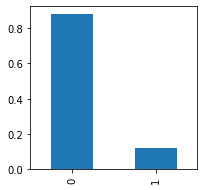

In [17]:
# 2)Random Forest model (n_estimators=8) and check its class balance.
forest = RandomForestClassifier(n_estimators=8, random_state=12345)
forest.fit(features_train, target_train)
forest_valid = pd.Series(forest.predict(features_valid))
forest_frequency = forest_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Random Forest model")
print(forest_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, forest_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, forest_valid))
print("Recall Score:", recall_score(target_valid, forest_valid))
print("Precision Score:", precision_score(target_valid, forest_valid))
print("F1 Score:", f1_score(target_valid, forest_valid))
forest_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Logistic Regression model
0    0.9272
1    0.0728
dtype: float64

Confusion Matrix:
 [[1890   75]
 [ 428  107]]

Accuracy Score: 0.7988
Recall Score: 0.2
Precision Score: 0.5879120879120879
F1 Score: 0.298465829846583


<AxesSubplot:>

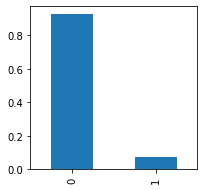

In [18]:
# 3) Logistic Regression model (solver='liblinear') and check its class balance.
logreg = LogisticRegression(solver='liblinear', random_state=12345)
logreg.fit(features_train, target_train)
logreg_valid = pd.Series(logreg.predict(features_valid))
logreg_frequency = logreg_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Logistic Regression model")
print(logreg_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, logreg_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, logreg_valid))
print("Recall Score:", recall_score(target_valid, logreg_valid))
print("Precision Score:", precision_score(target_valid, logreg_valid))
print("F1 Score:", f1_score(target_valid, logreg_valid))
logreg_frequency.plot(kind='bar', figsize=(3,3))

In all models we see a strong **Class Imbalance** that negatively affects their performance. The strong imbalance towards class 0 will make the models take a biased response in their predictions. This is reflected in the fact that, even thought **Accuracy** is relatively high in all models, they also present low **Recall**, **Precision** and **F1 scores**. After pre-processing the data for Machine Learning, we see that the poor performance of our models comes from the Class Imbalance in the data. We must correct this imbalance to improve performance.

## Correct Class Imbalance in the models

We will use several methods to correct Class Imbalance:<br>
**1) Using the class_weight='balanced' parameter in the models**

Class Frequency - Decision Tree model (balanced)
0    0.6584
1    0.3416
dtype: float64

Confusion Matrix:
 [[1520  445]
 [ 126  409]]

Accuracy Score: 0.7716
Recall Score: 0.7644859813084112
Precision Score: 0.47892271662763464
F1 Score: 0.5889128869690424


<AxesSubplot:>

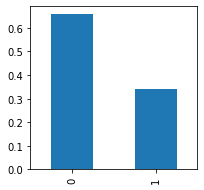

In [19]:
# 1)Decision Tree model (max_depth=6, class_weight='balanced') and check its class balance.
tree = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=12345)
tree.fit(features_train, target_train)
tree_valid = pd.Series(tree.predict(features_valid))
tree_frequency = tree_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Decision Tree model (balanced)")
print(tree_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, tree_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, tree_valid))
print("Recall Score:", recall_score(target_valid, tree_valid))
print("Precision Score:", precision_score(target_valid, tree_valid))
print("F1 Score:", f1_score(target_valid, tree_valid))
tree_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Random Forest model (balanced)
0    0.9008
1    0.0992
dtype: float64

Confusion Matrix:
 [[1904   61]
 [ 348  187]]

Accuracy Score: 0.8364
Recall Score: 0.34953271028037386
Precision Score: 0.7540322580645161
F1 Score: 0.4776500638569604


<AxesSubplot:>

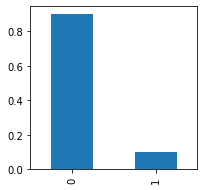

In [20]:
# 2)Random Forest model (n_estimators=8, class_weight='balanced') and check its class balance.
forest = RandomForestClassifier(n_estimators=8, class_weight='balanced', random_state=12345)
forest.fit(features_train, target_train)
forest_valid = pd.Series(forest.predict(features_valid))
forest_frequency = forest_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Random Forest model (balanced)")
print(forest_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, forest_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, forest_valid))
print("Recall Score:", recall_score(target_valid, forest_valid))
print("Precision Score:", precision_score(target_valid, forest_valid))
print("F1 Score:", f1_score(target_valid, forest_valid))
forest_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Logistic Regression model (balanced)
0    0.6216
1    0.3784
dtype: float64

Confusion Matrix:
 [[1395  570]
 [ 159  376]]

Accuracy Score: 0.7084
Recall Score: 0.702803738317757
Precision Score: 0.3974630021141649
F1 Score: 0.5077650236326806


<AxesSubplot:>

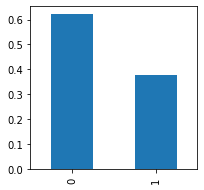

In [21]:
# 2) Logistic Regression model (solver='liblinear', class_weight='balanced') and check its class balance.
logreg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
logreg.fit(features_train, target_train)
logreg_valid = pd.Series(logreg.predict(features_valid))
logreg_frequency = logreg_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Logistic Regression model (balanced)")
print(logreg_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, logreg_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, logreg_valid))
print("Recall Score:", recall_score(target_valid, logreg_valid))
print("Precision Score:", precision_score(target_valid, logreg_valid))
print("F1 Score:", f1_score(target_valid, logreg_valid))
logreg_frequency.plot(kind='bar', figsize=(3,3))

Using the parameter **class_weight='balanced'** we slightly improved the F1 Score performance in both Decision Tree and Logistic Regression models.<br>
On the other hand, the F1 Score performance decreased on the Random Forest model.<br>

**Decision Tree**<br>
Accuracy Score: 0.85 to 0.77<br>
Recall Score: 0.41 to 0.76<br>
Precision Score: 0.81 to 0.48<br>
F1 Score: 0.55 to 0.59<br>

**Random Forest**<br>
Accuracy Score: 0.84 to 0.84<br>
Recall Score: 0.41 to 0.35<br>
Precision Score: 0.73 to 0.75<br>
F1 Score: 0.53 to 0.48<br>

**Logistic Regression**<br>
Accuracy Score: 0.80 to 0.71<br>
Recall Score: 0.20 to 0.70<br>
Precision Score: 0.59 to 0.40<br>
F1 Score: 0.30 to 0.51<br>

An improvement of the F1 Score reflects a better balance between Recall and Precision. This is the case for the Decision Tree and Logistic Regression models: Recall sharply improved in both models, while Precision diminished.<br>
The opposite is true for the Random Forest model: Recall diminished, while Precision improved.<br>
Based on these results, we conclude that the parameter *class_weight='balanced'* should be used on Decision Tree and Logistic Regression, but not in Random Forest.<br>
Even thought we see an improvement on the F1 scores, these are still too low to be accepted.

**2) Upsampling the training datasets**<br>
We will create a function to upsample and shuffle the training datasets, then train the models and evaluate their performance.

In [22]:
# Create a function to Upsample values in the trainings datasets
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 10
)

Class Frequency - Decision Tree model (upsampled)
1    0.5712
0    0.4288
dtype: float64

Confusion Matrix:
 [[1019  946]
 [  53  482]]

Accuracy Score: 0.6004
Recall Score: 0.9009345794392524
Precision Score: 0.33753501400560226
F1 Score: 0.49108507386653083


<AxesSubplot:>

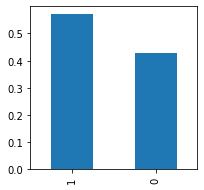

In [23]:
# 1)Decision Tree model (max_depth=6), train with upsampled dataset and check its class balance.
tree = DecisionTreeClassifier(max_depth=6, random_state=12345)
tree.fit(features_upsampled, target_upsampled)
tree_valid = pd.Series(tree.predict(features_valid))
tree_frequency = tree_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Decision Tree model (upsampled)")
print(tree_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, tree_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, tree_valid))
print("Recall Score:", recall_score(target_valid, tree_valid))
print("Precision Score:", precision_score(target_valid, tree_valid))
print("F1 Score:", f1_score(target_valid, tree_valid))
tree_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Random Forest model (upsampled)
0    0.8472
1    0.1528
dtype: float64

Confusion Matrix:
 [[1835  130]
 [ 283  252]]

Accuracy Score: 0.8348
Recall Score: 0.47102803738317756
Precision Score: 0.6596858638743456
F1 Score: 0.549618320610687


<AxesSubplot:>

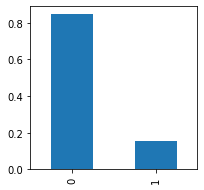

In [24]:
# 2)Random Forest model (n_estimators=8), train with upsampled dataset and check its class balance.
forest = RandomForestClassifier(n_estimators=8, random_state=12345)
forest.fit(features_upsampled, target_upsampled)
forest_valid = pd.Series(forest.predict(features_valid))
forest_frequency = forest_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Random Forest model (upsampled)")
print(forest_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, forest_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, forest_valid))
print("Recall Score:", recall_score(target_valid, forest_valid))
print("Precision Score:", precision_score(target_valid, forest_valid))
print("F1 Score:", f1_score(target_valid, forest_valid))
forest_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Logistic Regression model (upsampled)
1    0.7036
0    0.2964
dtype: float64

Confusion Matrix:
 [[ 700 1265]
 [  41  494]]

Accuracy Score: 0.4776
Recall Score: 0.9233644859813084
Precision Score: 0.2808413871517908
F1 Score: 0.4306887532693985


<AxesSubplot:>

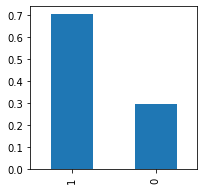

In [25]:
# 3) Logistic Regression model (solver='liblinear'), train with upsampled dataset and check its class balance.
logreg = LogisticRegression(solver='liblinear', random_state=12345)
logreg.fit(features_upsampled, target_upsampled)
logreg_valid = pd.Series(logreg.predict(features_valid))
logreg_frequency = logreg_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Logistic Regression model (upsampled)")
print(logreg_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, logreg_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, logreg_valid))
print("Recall Score:", recall_score(target_valid, logreg_valid))
print("Precision Score:", precision_score(target_valid, logreg_valid))
print("F1 Score:", f1_score(target_valid, logreg_valid))
logreg_frequency.plot(kind='bar', figsize=(3,3))

**Upsampling** the training datasets slightly decreased the F1 Score performance in the Decision Tree model, but it increased the performance in the Logistic Regression and Random Forest models.<br>

**Decision Tree**<br>
Accuracy Score: 0.85 to 0.60<br>
Recall Score: 0.41 to 0.90<br>
Precision Score: 0.81 to 0.34<br>
F1 Score: 0.55 to 0.49<br>

**Random Forest**<br>
Accuracy Score: 0.84 to 0.83<br>
Recall Score: 0.41 to 0.47<br>
Precision Score: 0.73 to 0.66<br>
F1 Score: 0.53 to 0.55<br>

**Logistic Regression**<br>
Accuracy Score: 0.80 to 0.48<br>
Recall Score: 0.20 to 0.92<br>
Precision Score: 0.59 to 0.28<br>
F1 Score: 0.30 to 0.43<br>

Based on these results, we conclude that the *Upsampled* training sets should be used in the Logistic Regression and Random Forest models,<br>
but not on the Decision Tree model.

**3) Downsampling the training datasets**<br>
We will create a function to downsample and shuffle the training datasets, then train the models and evaluate their performance.

In [26]:
# Create a function to Downsample the values in the training datasets:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.1
)

Class Frequency - Decision Tree model (downsampled)
1    0.5712
0    0.4288
dtype: float64

Confusion Matrix:
 [[1014  951]
 [  58  477]]

Accuracy Score: 0.5964
Recall Score: 0.891588785046729
Precision Score: 0.33403361344537813
F1 Score: 0.4859908303616913


<AxesSubplot:>

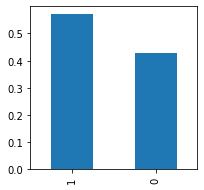

In [27]:
# 1)Decision Tree model (max_depth=6), train with downsampled dataset and check its class balance.
tree = DecisionTreeClassifier(max_depth=6, random_state=12345)
tree.fit(features_downsampled, target_downsampled)
tree_valid = pd.Series(tree.predict(features_valid))
tree_frequency = tree_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Decision Tree model (downsampled)")
print(tree_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, tree_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, tree_valid))
print("Recall Score:", recall_score(target_valid, tree_valid))
print("Precision Score:", precision_score(target_valid, tree_valid))
print("F1 Score:", f1_score(target_valid, tree_valid))
tree_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Random Forest model (downsampled)
1    0.51
0    0.49
dtype: float64

Confusion Matrix:
 [[1151  814]
 [  74  461]]

Accuracy Score: 0.6448
Recall Score: 0.8616822429906542
Precision Score: 0.3615686274509804
F1 Score: 0.5093922651933702


<AxesSubplot:>

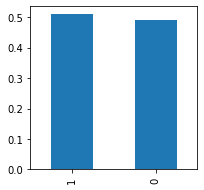

In [28]:
# 2)Random Forest model (n_estimators=8), train with downsampled dataset and check its class balance.
forest = RandomForestClassifier(n_estimators=8, random_state=12345)
forest.fit(features_downsampled, target_downsampled)
forest_valid = pd.Series(forest.predict(features_valid))
forest_frequency = forest_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Random Forest model (downsampled)")
print(forest_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, forest_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, forest_valid))
print("Recall Score:", recall_score(target_valid, forest_valid))
print("Precision Score:", precision_score(target_valid, forest_valid))
print("F1 Score:", f1_score(target_valid, forest_valid))
forest_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Logistic Regression model (downsampled)
1    0.6904
0    0.3096
dtype: float64

Confusion Matrix:
 [[ 728 1237]
 [  46  489]]

Accuracy Score: 0.4868
Recall Score: 0.914018691588785
Precision Score: 0.2833140208574739
F1 Score: 0.43255196815568336


<AxesSubplot:>

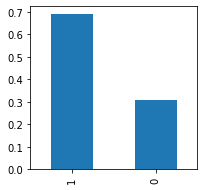

In [29]:
# 2) Logistic Regression model (solver='liblinear') and check its class balance.
logreg = LogisticRegression(solver='liblinear', random_state=12345)
logreg.fit(features_downsampled, target_downsampled)
logreg_valid = pd.Series(logreg.predict(features_valid))
logreg_frequency = logreg_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Logistic Regression model (downsampled)")
print(logreg_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, logreg_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, logreg_valid))
print("Recall Score:", recall_score(target_valid, logreg_valid))
print("Precision Score:", precision_score(target_valid, logreg_valid))
print("F1 Score:", f1_score(target_valid, logreg_valid))
logreg_frequency.plot(kind='bar', figsize=(3,3))

**Downsampling** the training datasets slightly decreased the F1 Score performance in the Decision Tree and Random Forest models, but it increased the performance in Logistic Regression. In fact, the Logistic Regression model seems to benefit almost identically from using the upsampled or downsampled sets.<br>

**Decision Tree**<br>
Accuracy Score: 0.85 to 0.60<br>
Recall Score: 0.41 to 0.89<br>
Precision Score: 0.81 to 0.33<br>
F1 Score: 0.55 to 0.49<br>

**Random Forest**<br>
Accuracy Score: 0.84 to 0.64<br>
Recall Score: 0.41 to 0.86<br>
Precision Score: 0.73 to 0.36<br>
F1 Score: 0.53 to 0.51<br>

**Logistic Regression**<br>
Accuracy Score: 0.80 to 0.49<br>
Recall Score: 0.20 to 0.91<br>
Precision Score: 0.59 to 0.28<br>
F1 Score: 0.30 to 0.43<br>

Based on these results, we could conclude that the *Downsampled* training sets should be used only on the Logistic Regression model, and not on the Decision Tree and Random Forest models.<br> 
However, an interesting result is that the Random Forest model presents a remarkably balanced class frequency when trained with the downsampled datasets.<br>
***Class Frequency - Random Forest model (downsampled)<br> 
1 - 0.51<br> 
0 - 0.49***<br> 
For this reason, it's worth considering using the downsampled set for the Random Forest model to optimize its performance.

## Optimizing the models
After applying the **class_weight='balanced'** parameter and **Upsampling/Downsampling** the training sets, we can conclude that:<br> 
• the **Decision Tree** model will show the best performance by using only the class_weight='balanced' parameter<br> 
• the **Random Forest** model will show the best performance either by using the upsampled or downsampled training sets.<br>
• the **Logistic Regression** model will benefit from using the class_weight='balanced' parameter, and working with either the upsampled or downsampled datasets.<br><br>

For this reason we will test five optimized models and evaluate their metrics in detail:<br>
1) Optimized Decision Tree model (class_weight='balanced')<br>
2) Optimized Random Forest model (upsampled)<br>
3) Optimized Random Forest model (downsampled)<br>
4) Optimized Logistic Regression (class_weight='balanced', upsampled)<br>
5) Optimized Logistic Regression (class_weight='balanced', downsampled)<br>

In [30]:
# Optimized Decision Tree model (class_weight='balanced')
tree = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=12345)
tree.fit(features_train, target_train)
tree_valid = tree.predict(features_valid)
# Create a Classification Report
print("Classification Report - Decision Tree model (optimized)")
print(classification_report(target_valid, tree_valid))

Classification Report - Decision Tree model (optimized)
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1965
           1       0.48      0.76      0.59       535

    accuracy                           0.77      2500
   macro avg       0.70      0.77      0.72      2500
weighted avg       0.83      0.77      0.79      2500



In [31]:
# Optimized Random Forest model (upsampled)
forest_up = RandomForestClassifier(n_estimators=8, random_state=12345)
forest_up.fit(features_upsampled, target_upsampled)
forest_up_valid = forest_up.predict(features_valid)
# Create a Classification Report
print("Classification Report - Random Forest model (upsampled)")
print(classification_report(target_valid, forest_up_valid))

Classification Report - Random Forest model (upsampled)
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1965
           1       0.66      0.47      0.55       535

    accuracy                           0.83      2500
   macro avg       0.76      0.70      0.72      2500
weighted avg       0.82      0.83      0.82      2500



In [32]:
# Optimized Random Forest model (downsampled)
forest_down = RandomForestClassifier(n_estimators=8, random_state=12345)
forest_down.fit(features_downsampled, target_downsampled)
forest_down_valid = forest_down.predict(features_valid)
# Create a Classification Report
print("Classification Report - Random Forest model (downsampled)")
print(classification_report(target_valid, forest_down_valid))

Classification Report - Random Forest model (downsampled)
              precision    recall  f1-score   support

           0       0.94      0.59      0.72      1965
           1       0.36      0.86      0.51       535

    accuracy                           0.64      2500
   macro avg       0.65      0.72      0.62      2500
weighted avg       0.82      0.64      0.68      2500



In [33]:
# Optimized Logistic Regression (class_weight='balanced', upsampled)
logreg_up = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
logreg_up.fit(features_upsampled, target_upsampled)
logreg_up_valid = logreg_up.predict(features_valid)
# Create a Classification Report
print("Classification Report - Logistic Regression (class_weight='balanced', upsampled)")
print(classification_report(target_valid, logreg_up_valid))

Classification Report - Logistic Regression (class_weight='balanced', upsampled)
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1965
           1       0.40      0.70      0.51       535

    accuracy                           0.71      2500
   macro avg       0.65      0.71      0.65      2500
weighted avg       0.79      0.71      0.73      2500



In [34]:
# Optimized Logistic Regression (class_weight='balanced', downsampled)
logreg_down = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
logreg_down.fit(features_downsampled, target_downsampled)
logreg_down_valid = logreg_down.predict(features_valid)
# Create a Classification Report
print("Classification Report - Logistic Regression (class_weight='balanced', downsampled)")
print(classification_report(target_valid, logreg_down_valid))

Classification Report - Logistic Regression (class_weight='balanced', downsampled)
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1965
           1       0.40      0.72      0.51       535

    accuracy                           0.71      2500
   macro avg       0.65      0.71      0.65      2500
weighted avg       0.79      0.71      0.73      2500



The optimized models greatly improved their **weighted averaged F1 scores**, which take into account the class imbalance:<br>
1) Optimized Decision Tree model (class_weight='balanced') = **0.79**<br>
2) Optimized Random Forest model (upsampled) = **0.82**<br>
3) Optimized Random Forest model (downsampled) = **0.68**<br>
4) Optimized Logistic Regression (class_weight='balanced', upsampled) = **0.73**<br>
5) Optimized Logistic Regression (class_weight='balanced', downsampled) = **0.73**<br><br>
***All the optimized models meet the minimum f1 score requirement (0.59).***

## Test reliability of the models using Predicted probabilities, PR curve, ROC curve and AUC-ROC score.
In all classification models, we can improve the performance by predicting the different probabilities for Recall and Precision with different Thresholds. We will predict the probabilities of the optimized models for different thresholds, using the **predict_proba()** function. We will then select an optimal Threshold (one that meets a good balance between Precision and Recall) and run classification reports to see how much more the models can be improved. Finally, we will plot graphs of **Precision/Recall and ROC curves** and **AUC-ROC Scores** for the optimized models, to see their relative performance against a random model (0.50 accuracy).<br>

In [35]:
# create function to evaluate Precision, Recall and F1 scores for different thresholds
def evaluate_thresholds(model, features, target, threshold_range=np.arange(0.5, 0.8, 0.04)):
    probabilities = model.predict_proba(features)[:, 1]

    for threshold in threshold_range:
        predicted = probabilities > threshold 
        precision = precision_score(target, predicted)
        recall = recall_score(target, predicted)
        f1 = f1_score(target, predicted)

        print(
            'Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 Score = {:.3f}'.format(
                threshold, precision, recall, f1
            )
        )

In [36]:
# Evaluate thresholds for all optimized models
print("1) Optimized Decision Tree model (class_weight='balanced')")
evaluate_thresholds(tree, features_valid, target_valid)

1) Optimized Decision Tree model (class_weight='balanced')
Threshold = 0.50 | Precision = 0.479, Recall = 0.764, F1 Score = 0.589
Threshold = 0.54 | Precision = 0.496, Recall = 0.725, F1 Score = 0.589
Threshold = 0.58 | Precision = 0.506, Recall = 0.710, F1 Score = 0.591
Threshold = 0.62 | Precision = 0.671, Recall = 0.533, F1 Score = 0.594
Threshold = 0.66 | Precision = 0.671, Recall = 0.533, F1 Score = 0.594
Threshold = 0.70 | Precision = 0.795, Recall = 0.450, F1 Score = 0.575
Threshold = 0.74 | Precision = 0.806, Recall = 0.450, F1 Score = 0.578
Threshold = 0.78 | Precision = 0.806, Recall = 0.450, F1 Score = 0.578


In [37]:
print("2) Optimized Random Forest model (upsampled)")
evaluate_thresholds(forest_up, features_valid, target_valid)

2) Optimized Random Forest model (upsampled)
Threshold = 0.50 | Precision = 0.660, Recall = 0.471, F1 Score = 0.550
Threshold = 0.54 | Precision = 0.660, Recall = 0.471, F1 Score = 0.550
Threshold = 0.58 | Precision = 0.660, Recall = 0.471, F1 Score = 0.550
Threshold = 0.62 | Precision = 0.660, Recall = 0.471, F1 Score = 0.550
Threshold = 0.66 | Precision = 0.739, Recall = 0.361, F1 Score = 0.485
Threshold = 0.70 | Precision = 0.739, Recall = 0.361, F1 Score = 0.485
Threshold = 0.74 | Precision = 0.739, Recall = 0.361, F1 Score = 0.485
Threshold = 0.78 | Precision = 0.822, Recall = 0.241, F1 Score = 0.373


In [38]:
print("3) Optimized Random Forest model (downsampled)")
evaluate_thresholds(forest_down, features_valid, target_valid)

3) Optimized Random Forest model (downsampled)
Threshold = 0.50 | Precision = 0.362, Recall = 0.862, F1 Score = 0.509
Threshold = 0.54 | Precision = 0.362, Recall = 0.862, F1 Score = 0.509
Threshold = 0.58 | Precision = 0.362, Recall = 0.862, F1 Score = 0.509
Threshold = 0.62 | Precision = 0.362, Recall = 0.862, F1 Score = 0.509
Threshold = 0.66 | Precision = 0.428, Recall = 0.761, F1 Score = 0.548
Threshold = 0.70 | Precision = 0.428, Recall = 0.761, F1 Score = 0.548
Threshold = 0.74 | Precision = 0.428, Recall = 0.761, F1 Score = 0.548
Threshold = 0.78 | Precision = 0.512, Recall = 0.596, F1 Score = 0.551


In [39]:
print("4) Optimized Logistic Regression (class_weight='balanced', upsampled)")
evaluate_thresholds(logreg_up, features_valid, target_valid)

4) Optimized Logistic Regression (class_weight='balanced', upsampled)
Threshold = 0.50 | Precision = 0.397, Recall = 0.703, F1 Score = 0.508
Threshold = 0.54 | Precision = 0.419, Recall = 0.654, F1 Score = 0.511
Threshold = 0.58 | Precision = 0.436, Recall = 0.589, F1 Score = 0.501
Threshold = 0.62 | Precision = 0.468, Recall = 0.536, F1 Score = 0.500
Threshold = 0.66 | Precision = 0.486, Recall = 0.456, F1 Score = 0.471
Threshold = 0.70 | Precision = 0.501, Recall = 0.370, F1 Score = 0.426
Threshold = 0.74 | Precision = 0.524, Recall = 0.308, F1 Score = 0.388
Threshold = 0.78 | Precision = 0.542, Recall = 0.243, F1 Score = 0.335


In [40]:
print("5) Optimized Logistic Regression (class_weight='balanced', downsampled)")
evaluate_thresholds(logreg_down, features_valid, target_valid)

5) Optimized Logistic Regression (class_weight='balanced', downsampled)
Threshold = 0.50 | Precision = 0.397, Recall = 0.716, F1 Score = 0.511
Threshold = 0.54 | Precision = 0.410, Recall = 0.662, F1 Score = 0.506
Threshold = 0.58 | Precision = 0.437, Recall = 0.611, F1 Score = 0.509
Threshold = 0.62 | Precision = 0.458, Recall = 0.555, F1 Score = 0.502
Threshold = 0.66 | Precision = 0.475, Recall = 0.486, F1 Score = 0.481
Threshold = 0.70 | Precision = 0.500, Recall = 0.407, F1 Score = 0.449
Threshold = 0.74 | Precision = 0.516, Recall = 0.335, F1 Score = 0.406
Threshold = 0.78 | Precision = 0.520, Recall = 0.262, F1 Score = 0.348


For all models, a **Threshold = 0.50 - 0.65** seems to meet a good balance between Precision/Recall and F1 score.<br><br>
The default threshold is 0.5. We can run Classification Reports to consider the weighted average F1 Scores under a higher threshold (0.65), which seems would further optimize the models . 

In [41]:
# Create function to run classification reports with thresholds = 0.65
def classification_report_with_threshold(model, features, target, threshold=0.65):
    probabilities = model.predict_proba(features)[:, 1]
    predicted = (probabilities >= threshold).astype(int)
    
    report = classification_report(target, predicted)
    
    print(f"Classification Report with Threshold {threshold}:\n{report}")
    
# Run Classification Reports for all optimized models
print("1) Optimized Decision Tree model (class_weight='balanced')")
classification_report_with_threshold(tree, features_valid, target_valid, threshold=0.65)
print("2) Optimized Random Forest model (upsampled)")
classification_report_with_threshold(forest_up, features_valid, target_valid, threshold=0.65)
print("3) Optimized Random Forest model (downsampled)")
classification_report_with_threshold(forest_down, features_valid, target_valid, threshold=0.65)
print("4) Optimized Logistic Regression (class_weight='balanced', upsampled)")
classification_report_with_threshold(logreg_up, features_valid, target_valid, threshold=0.65)
print("5) Optimized Logistic Regression (class_weight='balanced', downsampled)")
classification_report_with_threshold(logreg_down, features_valid, target_valid, threshold=0.65)

1) Optimized Decision Tree model (class_weight='balanced')
Classification Report with Threshold 0.65:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1965
           1       0.67      0.53      0.59       535

    accuracy                           0.84      2500
   macro avg       0.78      0.73      0.75      2500
weighted avg       0.83      0.84      0.84      2500

2) Optimized Random Forest model (upsampled)
Classification Report with Threshold 0.65:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1965
           1       0.74      0.36      0.48       535

    accuracy                           0.84      2500
   macro avg       0.79      0.66      0.69      2500
weighted avg       0.82      0.84      0.81      2500

3) Optimized Random Forest model (downsampled)
Classification Report with Threshold 0.65:
              precision    recall  f1-score   support

           

As expected, a custom Threshold of 0.65 would improve the weighted average f1 scores of most models:<br>
1) Optimized Decision Tree model (class_weight='balanced') = 0.79 to **0.84**<br>
2) Optimized Random Forest model (upsampled) = 0.82 to **0.81**<br>
3) Optimized Random Forest model (downsampled) = 0.68 to **0.75**<br>
4) Optimized Logistic Regression (class_weight='balanced', upsampled) = 0.73 to **0.78**<br>
5) Optimized Logistic Regression (class_weight='balanced', downsampled) = 0.73 to **0.78**<br><br>

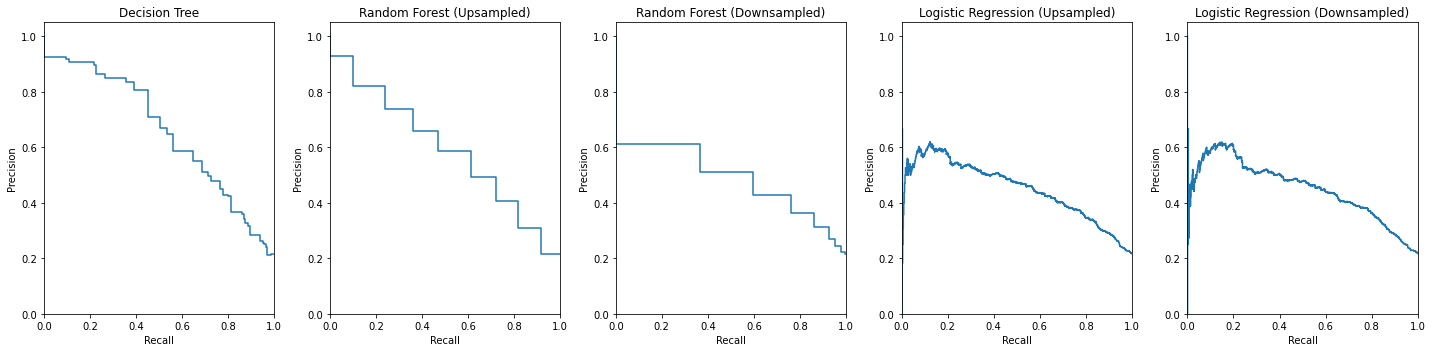

In [42]:
models = [tree, forest_up, forest_down, logreg_up, logreg_down]
model_names = ['Decision Tree', 'Random Forest (Upsampled)', 
               'Random Forest (Downsampled)', 'Logistic Regression (Upsampled)', 
               'Logistic Regression (Downsampled)']

def plot_precision_recall_curves(models, model_names, features_valid, target_valid, figsize=(20, 5)):
    plt.figure(figsize=figsize)

    for i, (model, model_name) in enumerate(zip(models, model_names), start=1):
        probabilities = model.predict_proba(features_valid)[:, 1]
        precision, recall, _ = precision_recall_curve(target_valid, probabilities)

        plt.subplot(1, len(models), i)
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(model_name)

    plt.tight_layout()
    plt.show()


# Plot PR curves for all optimized models
plot_precision_recall_curves(models, model_names, features_valid, target_valid)

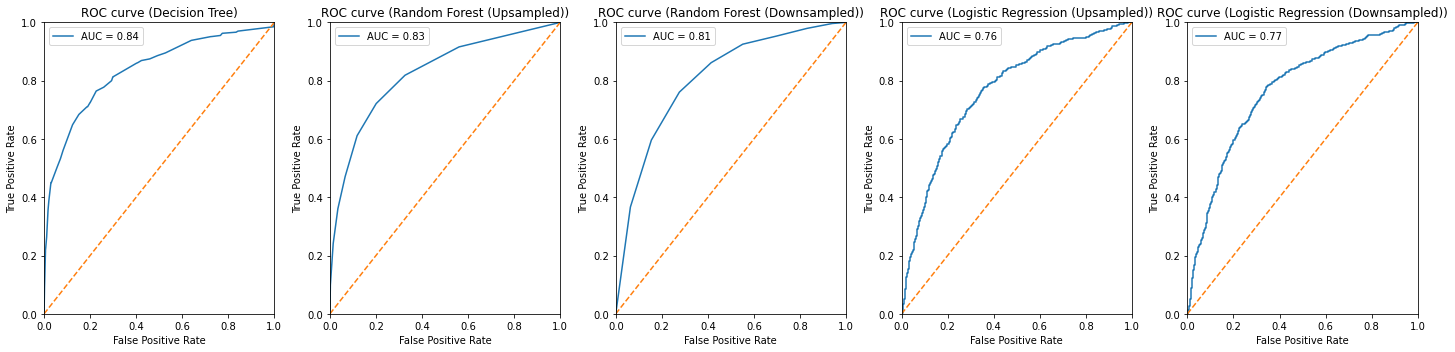

In [43]:
# Plot ROC Curves and AUC-ROC scores for all optimized models
# Create function to plot ROC curves and AUC-ROC scores
def plot_roc_curves(models, model_names, features_valid, target_valid, figsize=(20, 5)):
    plt.figure(figsize=figsize)

    for i, (model, model_name) in enumerate(zip(models, model_names), start=1):
        probabilities = model.predict_proba(features_valid)[:, 1]
        fpr, tpr, _ = roc_curve(target_valid, probabilities)
        auc = roc_auc_score(target_valid, probabilities)

        plt.subplot(1, len(models), i)
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC curve ({model_name})')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_roc_curves(models, model_names, features_valid, target_valid)

## Conclusion
The AUC scores of our optimized models range from 0.77 to 0.84, which makes them all acceptable models for predicting if the customers of Beta Bank are likely to remain as clients. The best model is Decision Tree with an AUC-ROC score of 0.84 and a weighted avg f1 score of 0.79-0.84.<br>
This project has shown that optimization analysis is highly effective in improving a model's performance. After cleaning and preparing the data for machine learning, and training different models, we initially found that each one of them had very low reliability (f1 score < 0.59). Fixing the class imbalance and analizying how each method affected the models, allowed us to make decisions that could marginally improve the performance in each specific case. Finally, testing the metrics of the optimized models (PR curve, ROC curve, AUC-ROC score) proved that these methods were highly effective in improving the model's performance as a whole. 